# **Data Preprocessing: Stage One**

1.	Splitting the training data (under sampling):
-	Get the durations for all the species
-	From the species with the shortest duration, make 70% of that duration the benchmark for the training duration of all the species for balanced training
-	The remaining samples will be the validation data
-	Turn all the data into a Mel-spectrograms (training and validation) (no normalization)
-	Make all the Mel-spectrograms the same dimensions
-	(Save that into a pkl file or something for easy access for all the models)


In [24]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1
import tensorflow as tf

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage

In [3]:
df_train = pd.read_csv('C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/traintest-split/train.csv') # Reading in training data
df_train.head()

,Unnamed: 0,primary_label,type,rating,filename,duration,filename_npy
0,7169,gargan,song,4.5,gargan/XC190746.ogg,6.660000,gargan/XC190746.npy
1,4476,combul2,song,3.5,combul2/XC443499.ogg,47.592000,combul2/XC443499.npy
2,7483,gnbcam2,blank,1.5,gnbcam2/XC45693.ogg,16.378812,gnbcam2/XC45693.npy
3,13632,tafpri1,call,4.0,tafpri1/XC363881.ogg,19.043250,tafpri1/XC363881.npy
4,14773,wbrcha2,song,3.5,wbrcha2/XC227360.ogg,93.753500,wbrcha2/XC227360.npy


In [4]:
df_train['primary_label'].value_counts()

primary_label
litegr     262
combul2    220
rbsrob1    190
greegr     183
blakit1    182
gnbcam2    174
rerswa1    156
somgre1    133
blbpuf2    123
ratcis1    123
tafpri1    121
colsun2    121
egygoo     113
categr     104
carcha1     97
gargan      94
yertin1     94
grecor      92
fotdro5     89
wbrcha2     86
Name: count, dtype: int64

In [5]:
filepaths = df_train['filename_npy']
filepaths

0        gargan/XC190746.npy
1       combul2/XC443499.npy
2        gnbcam2/XC45693.npy
3       tafpri1/XC363881.npy
4       wbrcha2/XC227360.npy
                ...         
2752    rerswa1/XC278139.npy
2753    rerswa1/XC310320.npy
2754    combul2/XC239845.npy
2755    somgre1/XC154317.npy
2756      grecor/XC27183.npy
Name: filename_npy, Length: 2757, dtype: object

## Get the durations for all the species

In [6]:
duration_sum = df_train[['primary_label', 'duration']].groupby('primary_label').sum('duration').reset_index().sort_values('primary_label', ascending=False)
duration_sum['duration_mins'] = duration_sum['duration'] / 60

duration_sum

,primary_label,duration,duration_mins
19,yertin1,3039.921813,50.665364
18,wbrcha2,4188.970125,69.816169
17,tafpri1,3091.966500,51.532775
16,somgre1,5975.104500,99.585075
15,rerswa1,5105.715938,85.095266
14,rbsrob1,8089.174500,134.819575
13,ratcis1,3813.778563,63.562976
12,litegr,6256.380688,104.273011
11,greegr,3072.503938,51.208399
10,grecor,6831.784187,113.863070


### From the species with the shortest duration, make 70% of that duration the benchmark for the training duration of all the species for balanced training

In [9]:
train_duration_max = np.min(duration_sum['duration'])*0.7 # maximum total duration for each species in the training set in seconds using sample with shortest duration
train_duration_max

1516.1806624999997

In [10]:
shuffled_train = df_train.sample(frac=1, random_state=1414) # shuffle the original df before splitting to train/val

In [30]:
df_train

,Unnamed: 0,primary_label,type,rating,filename,duration,filename_npy
0,7169,gargan,song,4.5,gargan/XC190746.ogg,6.660000,gargan/XC190746.npy
1,4476,combul2,song,3.5,combul2/XC443499.ogg,47.592000,combul2/XC443499.npy
2,7483,gnbcam2,blank,1.5,gnbcam2/XC45693.ogg,16.378812,gnbcam2/XC45693.npy
3,13632,tafpri1,call,4.0,tafpri1/XC363881.ogg,19.043250,tafpri1/XC363881.npy
4,14773,wbrcha2,song,3.5,wbrcha2/XC227360.ogg,93.753500,wbrcha2/XC227360.npy
...,...,...,...,...,...,...,...
2752,11913,rerswa1,call,4.0,rerswa1/XC278139.ogg,34.351062,rerswa1/XC278139.npy
2753,11921,rerswa1,call,2.0,rerswa1/XC310320.ogg,2.063687,rerswa1/XC310320.npy
2754,4314,combul2,song,5.0,combul2/XC239845.ogg,103.418813,combul2/XC239845.npy
2755,12692,somgre1,song,4.5,somgre1/XC154317.ogg,26.435938,somgre1/XC154317.npy


In [11]:
# Adding samples to each species until the duration of each species = train_duration_max
tr = pd.DataFrame()

for species in shuffled_train['primary_label'].unique():
  species_df = shuffled_train[shuffled_train['primary_label'] == species].copy()
  duration = 0

  while duration <= train_duration_max:
        sample = species_df.sample(n=1, replace=False, random_state=1)  # draw one sample and don't put it back
        species_df.drop(sample.index, inplace=True)
        duration += sample['duration'].item()
        tr = pd.concat([tr, sample])

In [28]:
tr

,Unnamed: 0,primary_label,type,rating,filename,duration,filename_npy,set
47,8095,greegr,call,2.5,greegr/XC528049.ogg,2.324937,greegr/XC528049.npy,tr
1730,8075,greegr,call,0.0,greegr/XC473082.ogg,27.167000,greegr/XC473082.npy,tr
1790,8038,greegr,call,4.0,greegr/XC397338.ogg,24.032000,greegr/XC397338.npy,tr
1359,8034,greegr,call,4.5,greegr/XC361135.ogg,24.398375,greegr/XC361135.npy,tr
2173,8153,greegr,call,4.0,greegr/XC669884.ogg,6.024000,greegr/XC669884.npy,tr
...,...,...,...,...,...,...,...,...
2076,11949,rerswa1,call,3.0,rerswa1/XC334160.ogg,12.240000,rerswa1/XC334160.npy,tr
1360,12050,rerswa1,blank,4.0,rerswa1/XC697561.ogg,1.645750,rerswa1/XC697561.npy,tr
2525,11869,rerswa1,both,1.0,rerswa1/XC178397.ogg,6.687000,rerswa1/XC178397.npy,tr
2036,11985,rerswa1,call,5.0,rerswa1/XC423911.ogg,10.866938,rerswa1/XC423911.npy,tr


In [12]:
val = df_train.drop(tr.index) # Samples not selected in train, take them to val

### Confirm no duplicates and the samples in validation set are not in the training set

In [13]:
assert len(tr) == tr['filename_npy'].nunique()

In [14]:
assert len(val) == val['filename_npy'].nunique()

In [15]:
is_present = val.isin(tr).any().any()

assert not is_present

### Combining the training and validation sets into one set with a column identifying the set the samples belong to

In [16]:
tr['set'] = 'tr'
val['set'] = 'val'

merged_train = pd.concat([tr, val])

In [17]:
duration_sum = merged_train[['primary_label', 'duration', 'set']].groupby(['set', 'primary_label']).sum('duration').reset_index().sort_values('primary_label', ascending=False)
duration_sum['duration_mins'] = duration_sum['duration'] / 60

duration_sum

,set,primary_label,duration,duration_mins
39,val,yertin1,1432.661500,23.877692
19,tr,yertin1,1607.260313,26.787672
18,tr,wbrcha2,1524.414750,25.406912
38,val,wbrcha2,2664.555375,44.409256
17,tr,tafpri1,1536.814187,25.613570
37,val,tafpri1,1555.152312,25.919205
16,tr,somgre1,1569.966250,26.166104
36,val,somgre1,4405.138250,73.418971
35,val,rerswa1,3541.760625,59.029344
15,tr,rerswa1,1563.955312,26.065922


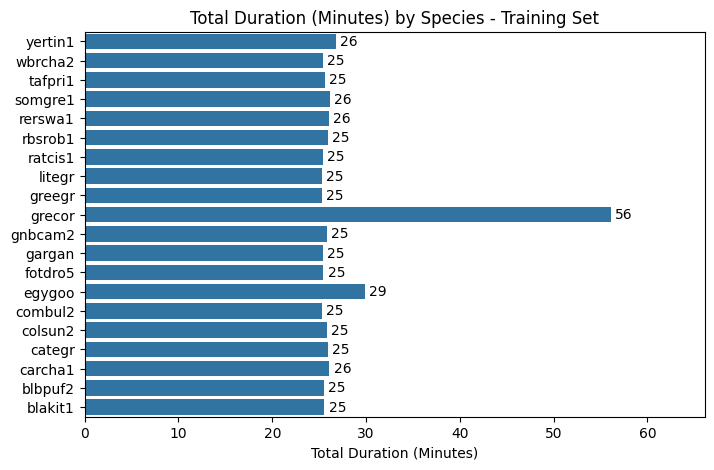

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

sns.barplot(x='duration_mins', y='primary_label', data=duration_sum[duration_sum['set'] =='tr'], ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='tr']['duration_mins']) + 10])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Training Set')

plt.show()

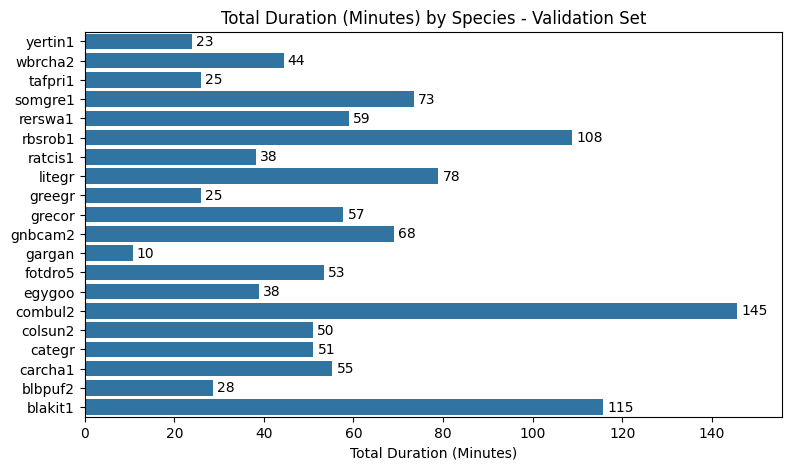

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,5))

sns.barplot(x='duration_mins', y='primary_label', data=duration_sum[duration_sum['set'] =='val'], ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='val']['duration_mins']) + 10])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Validation Set')

plt.show()

In [23]:
merged_train.to_csv('C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/trainval-split/stage-1-trainval.csv', index=False)

# Feature Extraction

Turning the data into Mel-spectrograms 

In [32]:
npy_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/train_audio_npy/'  # Path to audio npy files
save_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-1/'  # Where to save Mel spectrograms
n_mels = 128
target_shape = (128,128)
sr = 16000

In [36]:
# Loading the train-validation split CSV
csv_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/trainval-split/stage-1-trainval.csv'
trainval_data = pd.read_csv(csv_path)
train_data = trainval_data[trainval_data['set'] == 'tr']
val_data = trainval_data[trainval_data['set'] == 'val']

In [35]:
train_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-1/train_mel_spectrograms.pkl'
val_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-1/val_mel_spectrograms.pkl'


In [33]:
# Function to convert audio numpy array to resized Mel spectrogram
def get_mel_spectrogram_squeeze_stretch(npy_file, sr=sr, n_mels=n_mels, hop_length=512, target_shape=target_shape):
    # Load audio data
    audio_data = np.load(npy_path + npy_file)

    # Generate the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Resize the Mel spectrogram to the target shape
    mel_spectrogram_resized = scipy.ndimage.zoom(mel_spectrogram_db, (target_shape[0] / mel_spectrogram_db.shape[0], 
                                                                      target_shape[1] / mel_spectrogram_db.shape[1]))

    return mel_spectrogram_resized

## Processing the training data

In [37]:
train_mel_spectrograms = {}
for _, row in tqdm(train_data.iterrows(), desc="Processing training Mel spectrograms", total=len(train_data)):
    npy_file = row['filename_npy']
    label = row['primary_label']
    
    # Generate and save Mel spectrogram
    mel_spec = get_mel_spectrogram_squeeze_stretch(npy_file)
    
    # Save as a tuple of (mel_spectrogram, label) for easy future access
    train_mel_spectrograms[npy_file] = (mel_spec, label)

Processing training Mel spectrograms: 100%|██████████| 933/933 [00:29<00:00, 31.78it/s]


In [38]:
with open(train_pkl_path, 'wb') as f:
    pickle.dump(train_mel_spectrograms, f)

## Processing the validation data

In [40]:
val_mel_spectrograms = {}
for _, row in tqdm(val_data.iterrows(), desc="Processing validation Mel spectrograms", total=len(val_data)):
    npy_file = row['filename_npy']
    label = row['primary_label']
    
    # Generate and save Mel spectrogram
    mel_spec = get_mel_spectrogram_squeeze_stretch(npy_file)
    
    # Save as a tuple of (mel_spectrogram, label) for easy future access
    val_mel_spectrograms[npy_file] = (mel_spec, label)

Processing validation Mel spectrograms: 100%|██████████| 1824/1824 [01:08<00:00, 26.61it/s]


In [41]:
# Save validation mel spectrograms to pickle
with open(val_pkl_path, 'wb') as f:
    pickle.dump(val_mel_spectrograms, f)

## Plotting the spectrograms

So you can see that its not really a good way to do it this way

In [43]:
# Function to plot mel spectrogram
def plot_mel_spectrogram(mel_spec, label, sr=sr, hop_length=512):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram for {label}')
    plt.tight_layout()
    plt.show()

In [53]:
val_mel_keys = list(val_mel_spectrograms.keys())

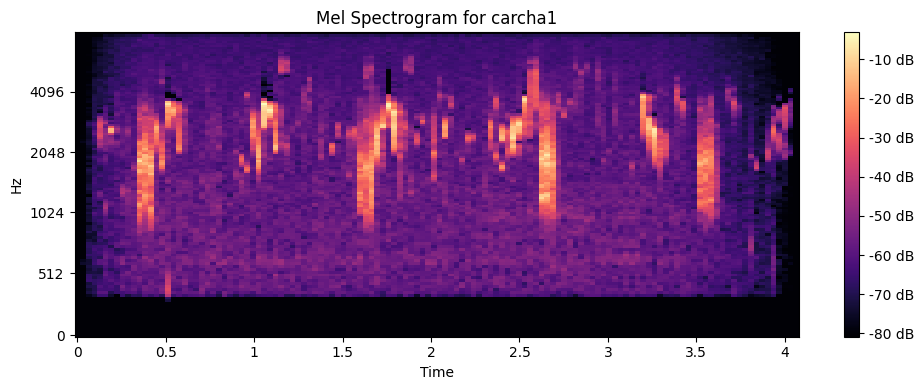

In [63]:
index = 901
npy_file = val_mel_keys[index]
mel_spec, label = val_mel_spectrograms[npy_file]
plot_mel_spectrogram(mel_spec, label)

# Confirming that the pickle files were saved correctly:

In [67]:
with open(train_pkl_path, 'rb') as f:
    train_mel_spectrograms = pickle.load(f)

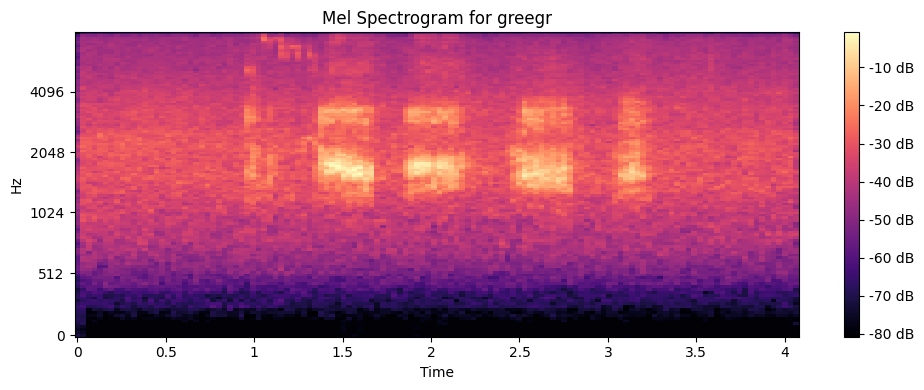

In [72]:
train_keys = list(train_mel_spectrograms.keys())
index = 9
npy_file = train_keys[index]
mel_spec, label = train_mel_spectrograms[npy_file]
plot_mel_spectrogram(mel_spec, label)

In [ ]:
with open(val_pkl_path, 'rb') as f:
    val_mel_spectrograms = pickle.load(f)

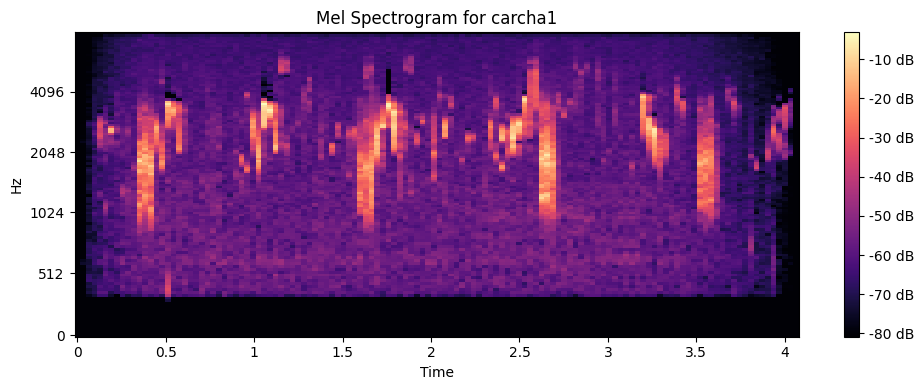

In [74]:
val_keys = list(val_mel_spectrograms.keys())
index = 900
npy_file = val_keys[index]
mel_spec, label = val_mel_spectrograms[npy_file]
plot_mel_spectrogram(mel_spec, label)